# Experimentos y análisis


In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import os

CPU_EXEC = "../build/src/MyProjectCPU"
CL_EXEC = "../build/src/cl/MyProjectCL"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"

## Experimento 1
Variar el tamaño del arreglo con `block_size` y `grid_size` fijos

- Párametros:
    - $N$: De $2^5$ a $2^{20}$

In [3]:

current_path = os.getcwd()
block = 1024
grid = 8

for i in range(5, 21):
    size = 2**i
    print("Running for size", size)
    # do 10 runs for each size
    for _ in range(10):
        subprocess.run([CPU_EXEC, str(size), current_path + "/cpu.csv"], stdout=subprocess.DEVNULL)
        subprocess.run([CL_EXEC, str(size), str(block), str(grid*block), current_path + "/cl.csv"], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC, str(size), str(block), str(grid*block), current_path + "/cuda.csv"], stdout=subprocess.DEVNULL)

Running for size 32


: 

### Análisis

In [4]:
cpu = pd.read_csv("nbody_naive_cpu.csv", header=None)

naive_cl = pd.read_csv("nbody_naive_cl.csv", header=None)
local_mem_cl = pd.read_csv("nbody_local_mem_cl.csv", header=None)
bidimensional_cl = pd.read_csv("nbody_bidimensional_cl.csv", header=None)

cpu.columns = ["size", "data creation time", "execution time", "total time"]

cl_columns = ["size", "local size", "global size", "local size y", "global size y", "local mem size", "create data time", "copy to device", "execution time", "copy to host"]
naive_cl.columns = cl_columns
local_mem_cl.columns = cl_columns
bidimensional_cl.columns = cl_columns

naive_cl["total time"] = naive_cl["create data time"] + naive_cl["copy to device"] + naive_cl["execution time"] + naive_cl["copy to host"]
local_mem_cl["total time"] = local_mem_cl["create data time"] + local_mem_cl["copy to device"] + local_mem_cl["execution time"] + local_mem_cl["copy to host"]
bidimensional_cl["total time"] = bidimensional_cl["create data time"] + bidimensional_cl["copy to device"] + bidimensional_cl["execution time"] + bidimensional_cl["copy to host"]

# cuda.columns = ["size", "block size", "grid size", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

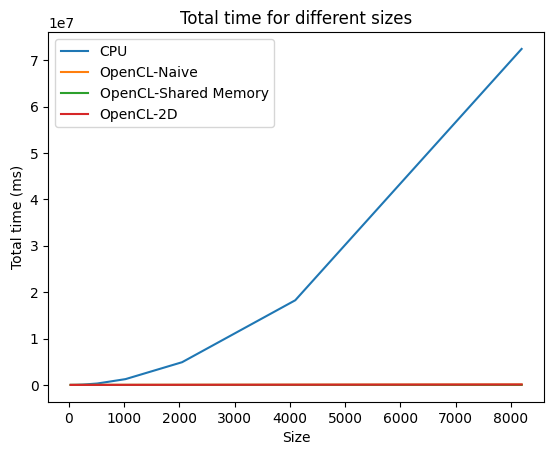

In [6]:
# plot avg total time for each size
cpu_avg = cpu.groupby("size").mean()
naive_cl_avg = naive_cl.groupby("size").mean()
local_mem_cl_avg = local_mem_cl.groupby("size").mean()
bidimensional_cl_avg = bidimensional_cl.groupby("size").mean()

# cuda_avg = cuda.groupby("size").mean()

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["total time"], label="CPU")
ax.plot(naive_cl_avg.index, naive_cl_avg["total time"], label="OpenCL-Naive")
ax.plot(local_mem_cl_avg.index, local_mem_cl_avg["total time"], label="OpenCL-Shared Memory")
ax.plot(bidimensional_cl_avg.index, bidimensional_cl_avg["total time"], label="OpenCL-2D")
# ax.plot(cuda_avg.index, cuda_avg["total time"], label="CUDA")
ax.set_xlabel("Size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()

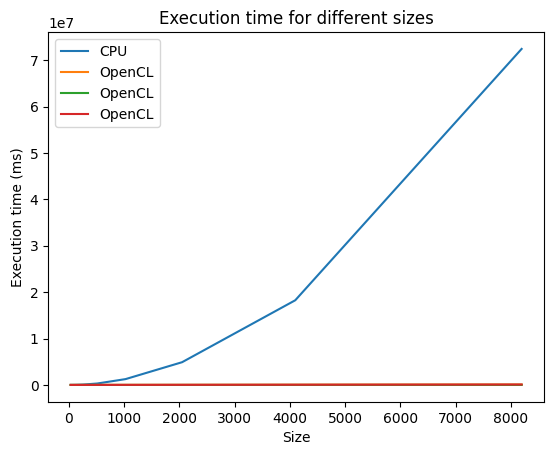

In [8]:
# plot avg execution time for each size
fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["execution time"], label="CPU")
ax.plot(naive_cl_avg.index, naive_cl_avg["execution time"], label="OpenCL")
ax.plot(local_mem_cl_avg.index, local_mem_cl_avg["execution time"], label="OpenCL")
ax.plot(bidimensional_cl_avg.index, bidimensional_cl_avg["execution time"], label="OpenCL")
# ax.plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA")
ax.set_xlabel("Size")
ax.set_ylabel("Execution time (ms)")
ax.legend()
plt.title("Execution time for different sizes")
plt.show()

In [10]:
# print speedup on execution time
speedup_naive_cl = cpu_avg["execution time"] / naive_cl_avg["execution time"]
speedup_shared_cl = cpu_avg["execution time"] / local_mem_cl_avg["execution time"]
speedup_bidimensional_cl = cpu_avg["execution time"] / bidimensional_cl_avg["execution time"]
# speedup_cuda = cpu_avg["execution time"] / cuda_avg["execution time"]

print("Speedup Naive OpenCL")
print(speedup_naive_cl)
print("Speedup Shared Memory OpenCL")
print(speedup_shared_cl)
print("Speedup Bidimensional Mapping OpenCL")
print(speedup_bidimensional_cl)

Speedup Naive OpenCL
size
32        3.206986
64        6.715311
128      12.865917
256      26.909646
512      55.093165
1024    115.641472
2048    227.983236
4096    423.556002
8192    828.751035
Name: execution time, dtype: float64
Speedup Shared Memory OpenCL
size
32         12.371042
64         40.533958
128        77.413900
256       268.447814
512       871.431467
1024     2635.824669
2048     6360.599953
4096    13227.002430
8192    32079.235839
Name: execution time, dtype: float64
Speedup Bidimensional Mapping OpenCL
size
32        6.847976
64        8.761085
128      13.225051
256      27.629553
512      56.632552
1024    118.977010
2048    234.673273
4096    436.825450
8192    873.857653
Name: execution time, dtype: float64


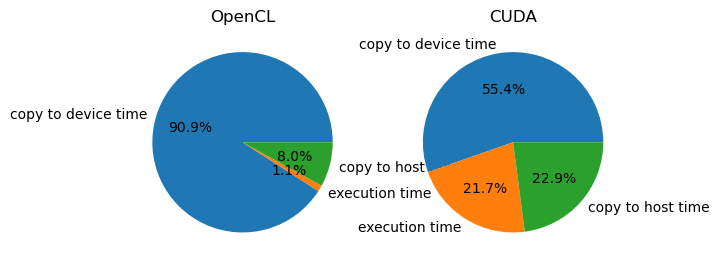

In [20]:
cl_avg["data creation time"] /= cl_avg.index
cl_avg["copy to device time"] /= cl_avg.index
cl_avg["execution time"] /= cl_avg.index
cl_avg["copy to host time"] /= cl_avg.index

cuda_avg["data creation time"] /= cuda_avg.index
cuda_avg["copy to device time"] /= cuda_avg.index
cuda_avg["execution time"] /= cuda_avg.index
cuda_avg["copy to host time"] /= cuda_avg.index

# plot a two pie chart of the average time spent on each step for OpenCL and CUDA
fig, ax = plt.subplots(1, 2)
ax[0].pie(cl_avg.iloc[0][3:6], labels=cl_avg.columns[3:6], autopct='%1.1f%%')
ax[0].set_title("OpenCL")
ax[1].pie(cuda_avg.iloc[0][3:6], labels=cuda_avg.columns[3:6], autopct='%1.1f%%')
ax[1].set_title("CUDA")
plt.show()



### Conclusión
- Para arreglos de tamaño menor o igual a $2^{20}$ el rendimiento en CPU y GPU es similar
- Existen un gran speedup en *tiempo de ejecución* no asi en *tiempo total* del programa
- En OpenCL el mayor problema esta en el paso de memoria de CPU a GPU.
- En CUDA también se repite este problema pero esta más equilibrado.